In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

# Birth & Death

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
special_probs = {"birth": 0.5, "death": 0.5}
#special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

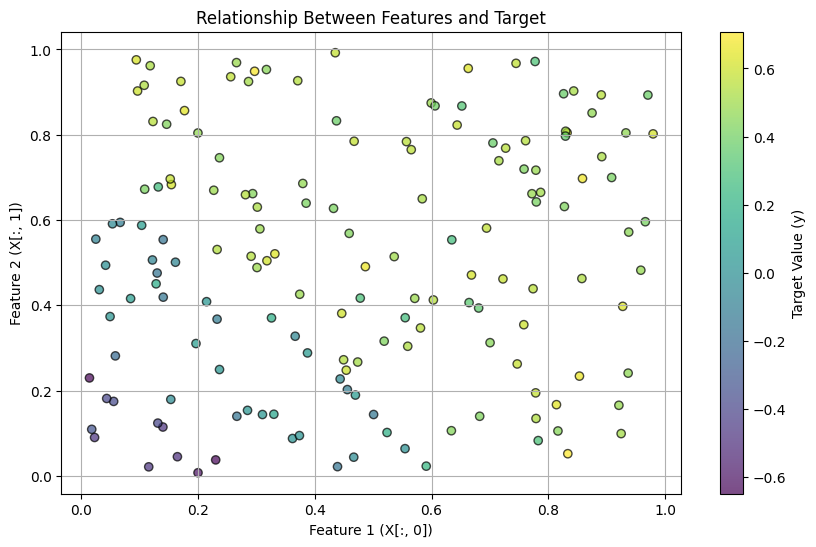

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

In [4]:
n_trees_ini = 50
nskip = 30000
theta_0_nskip_prop=0.4
def temperature_schedule(t):
    t_start = theta_0_nskip_prop * nskip
    if t <= t_start:
        return 1.0
    else:
        t_max = (theta_0_nskip_prop+0.4) * nskip
        temp_min = 0.1
        temp = 1.0 - (t - t_start) * (1.0 - temp_min) / (t_max - t_start)
        return max(temp, temp_min)
bart = ChangeNumTreeBART(ndpost=10000, nskip=nskip, n_trees=n_trees_ini, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0_ini = n_trees_ini, theta_0_min = 10, theta_0_nskip_prop=theta_0_nskip_prop, theta_df = 100, 
                         temperature = TemperatureSchedule(temperature_schedule),
                         #temperature = 1.0,
                         tree_num_prior_type="poisson", special_move_interval=5)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 40000/40000 [03:25<00:00, 194.65it/s]


In [5]:
bart.trace[-1].n_trees

22

In [6]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.0025871]), 'ntree_theta': 10.638844715354981}

In [7]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

22.0

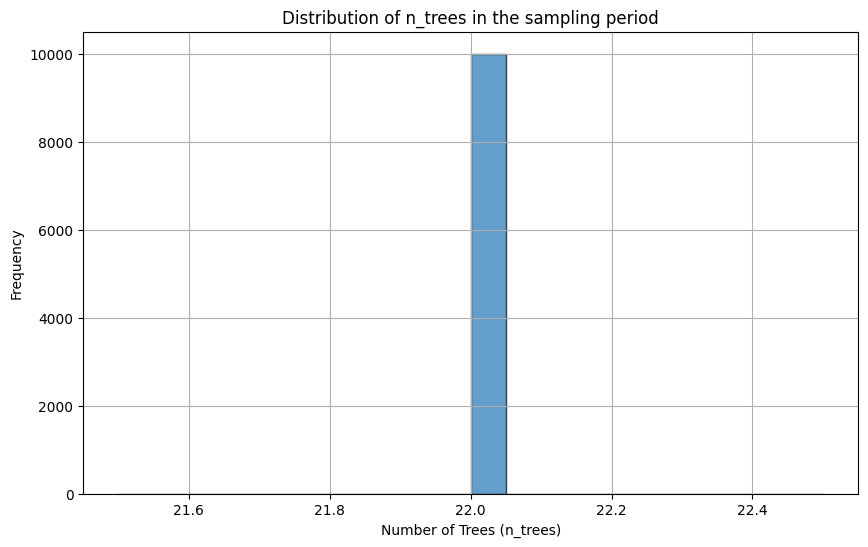

In [8]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

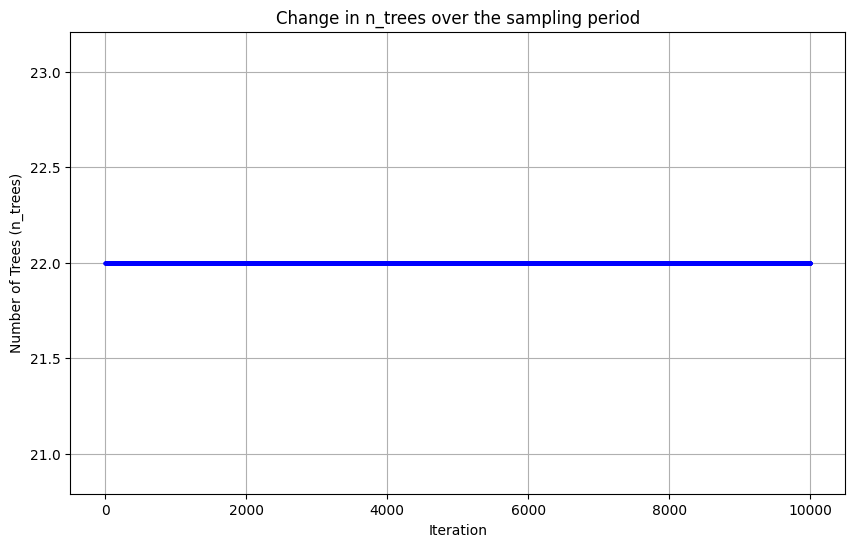

In [9]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [10]:
# Extract ntree_theta from global_params for each trace
ntree_theta_list = [trace.global_params['ntree_theta'] for trace in bart.trace]
np.mean(ntree_theta_list)

11.986324079210393

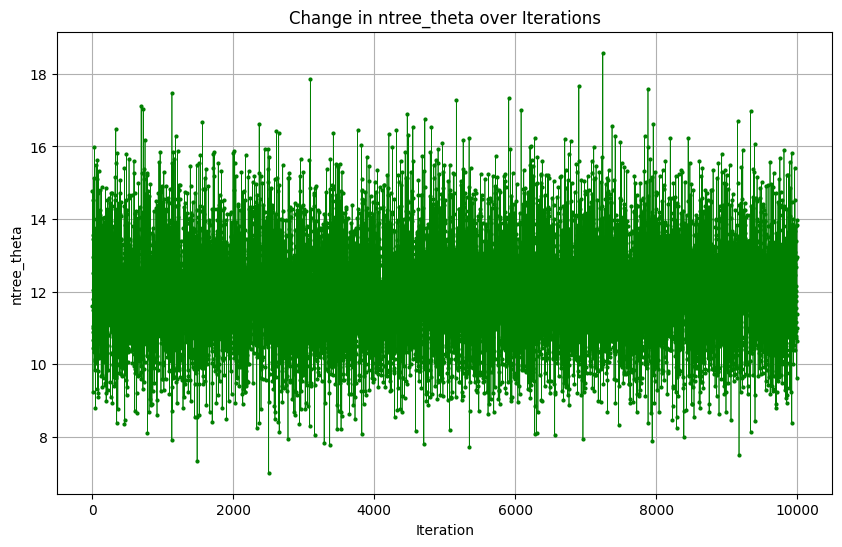

In [11]:
# Plot ntree_theta over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(ntree_theta_list)), ntree_theta_list, marker='o', markersize=2, linestyle='-', linewidth=0.5, color='g')
plt.title('Change in ntree_theta over Iterations')
plt.xlabel('Iteration')
plt.ylabel('ntree_theta')
plt.grid(True)
plt.show()

In [12]:
print(f'Birth move count: {len(bart.sampler.birth_mh_ratios)}; mh median: {np.median(bart.sampler.birth_mh_ratios)}')

Birth move count: 4062; mh median: 0.22253294652679032


In [13]:
print(f'Death move count: {len(bart.sampler.death_mh_ratios)}; mh median: {np.median(bart.sampler.death_mh_ratios)}')

Death move count: 91; mh median: 20.257123479507094


In [14]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-05-20 15:55:27,739:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-20 15:55:27,742:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.45 P_prune=0.55 A_grow=0.40 A_prune=0.42 (burnin)
Iteration 200/300 P_grow=0.41 P_prune=0.59 A_grow=0.33 A_prune=0.31
Iteration 300/300 P_grow=0.59 P_prune=0.41 A_grow=0.46 A_prune=0.44


In [15]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.030645078035804435,
 'rf': 0.020067464318210982,
 'lr': 0.048045521328019404,
 'btz': 0.02872495042825864}

In [16]:
bart.trace[-1].trees

[Tree(vars=[ 1  0 -1 -1 -1 -2 -2 -2], thresholds=[0.96070553 0.0758593         nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan         nan  0.04117845  0.01833271 -0.0451697          nan
          nan         nan], n_vals=[120 118   2  10 108  -2  -2  -2]),
 Tree(vars=[ 0 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.04302845        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan  0.02667195 -0.01815793         nan         nan         nan
          nan         nan], n_vals=[120   5 115  -2  -2  -2  -2  -2]),
 Tree(vars=[ 0  1 -1 -1 -1 -2 -2 -2], thresholds=[0.93705634 0.80467157        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan         nan -0.02080085 -0.02432426  0.05264975         nan
          nan         nan], n_vals=[120 115   5  95  20  -2  -2  -2]),
 Tree(vars=[ 1  0 -1 -1  1 -2 -2 -2 -2 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.82685667 0.0758593         nan      

In [17]:
if all([(bart.sampler.trace[-1].trees[i].evaluate() == bart.sampler.trace[-1].trees[i].evaluate(X_train)).all()
            for i in range(bart.sampler.trace[-1].n_trees)]):
    print("True")
else:
    print("False")

True


In [18]:
np.allclose(bart.sampler.trace[-1].evaluate(X_train), bart.sampler.trace[-1].evaluate(), atol=1e-10, rtol=1e-12)

True